In [499]:
# Program to analyze the TOF of the dipole trap

import os
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import math
from scipy.optimize import least_squares,leastsq,curve_fit

In [500]:
system = 'Mac'

if system == 'Mac':
    folder_path1 = '/Volumes/Users/AMO lab/Documents/Rydberg Data/2024/0111/4/'
else:
    folder_path1 = 'C:\\Users\\AMO lab\\Documents\\Rydberg Data\\2024\\0109'

probe = plt.imread(folder_path1 + '/' + 'probe.png').astype(np.float64)
# bg = plt.imread(folder_path1 + '\\bg.png').astype(np.float64)

time = np.arange(0,0.52,0.025) 
img = np.zeros((len(time), probe.shape[0],probe.shape[1]))
for i in range(0,len(time)):
    # print(i)
    if system == 'Mac':
        img_temp = plt.imread(folder_path1+ 'data_' + str(i)+'.png')
    else:
        img_temp = plt.imread(folder_path1+ '\\data_' + str(i) + '.png')
        img_temp = img_temp.astype(np.float64)
    img[i,:,:]=img_temp

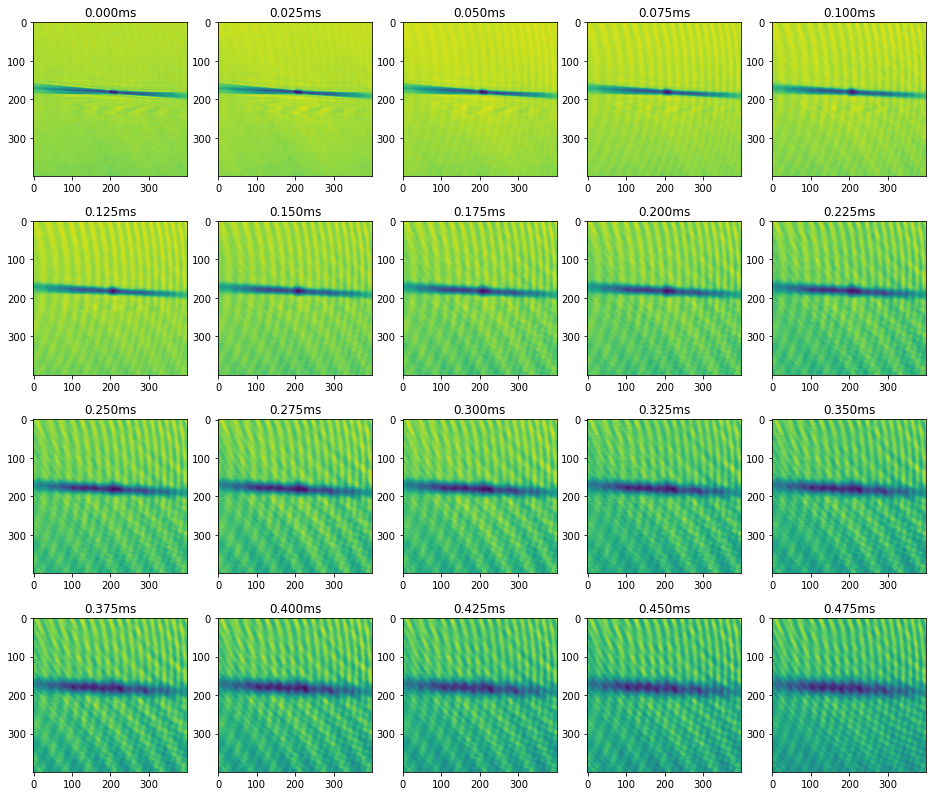

In [501]:
a = 500
b = 900
c = 500
d = 900
img_crop = img[:,a:b,c:d]
probe_crop = probe[a:b,c:d]
ab1 = img_crop / probe_crop
plt.figure(figsize = [16,14])
for i in range(20):
    plt.subplot(4,5,i+1)
    plt.imshow((ab1[i,:,:]))
    plt.title('%.3f'%time[i] + 'ms')
    # plt.colorbar()

plt.savefig(folder_path1 + 'absorption.png')



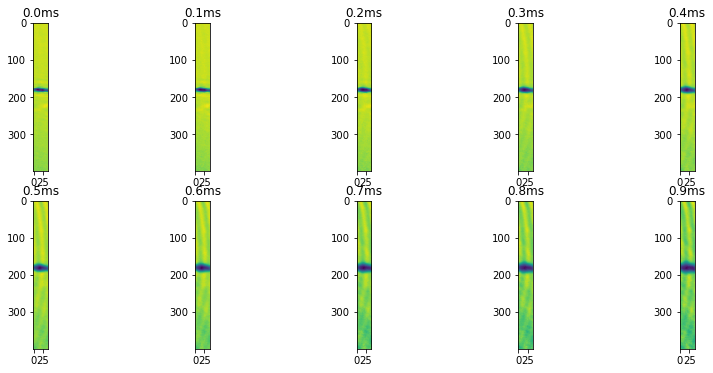

In [502]:
a1 = 190
b1 = 230
img_shape= img_crop[:,:,a1:b1]
probe_shape = probe_crop[:,a1:b1]
ab2 = img_shape/ probe_shape
plt.figure(figsize = [14,6])
for i in range(10):
    plt.subplot(2,5,i+1)
    plt.imshow((ab2[i,:,:]))
    plt.title('%.1f'%(0.1*i) + 'ms')
plt.savefig(folder_path1 + 'absorption_crop.png')

(21, 130)


Text(0.5, 15.0, 'x (pixel)')

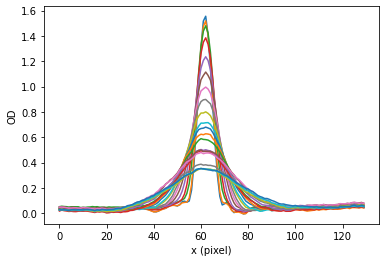

In [503]:
img_1D = img_shape.sum(axis = 2) 

ab_1D = img_1D /  probe_shape.sum(axis = 1)
ab_1D = ab_1D[:,120:250]
print(ab_1D.shape)
plt.plot(-np.transpose(np.log(ab_1D)))
plt.savefig(folder_path1 + '\\absorption_1D.png')
plt.ylabel('OD')
plt.xlabel('x (pixel)')

21
(21, 4)


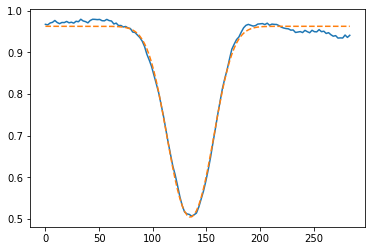

In [504]:
def gaussian_OD(x, amplitude, xo, sigma, bias = 0):
    xo = float(xo)
    g = amplitude * np.exp(-( (x - xo)**2 / (2* sigma**2) )) + bias
    return np.exp(-g)

x = np.arange(250-120) * 5.86 * 150/400
popt = np.zeros((img_1D.shape[0],4))
print(len(img_1D))
for i in range(len(img_1D)):
    # print(i)
    popt1, pcov1 = curve_fit(gaussian_OD, x, ab_1D[i,:],p0=[0.1,120,100,0])
    popt[i,:] = popt1#np.array(popt1)
print(popt.shape)
plt.plot(x,ab_1D[10,:])
plt.plot(x,gaussian_OD(x,popt[10,0],popt[10,1],popt[10,2],popt[10,3]),'--')

32.49925620351011 um 41.74766663492561 uK


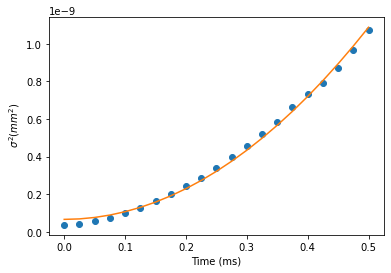

In [505]:
sigma = popt[:,2]
sigma_2 = popt[:,2]**2*1e-12


k_B = 1.3806504e-23
# Atomic mass of Rb85
m = 1.409993199e-25
# Gravitational aceleration
g = 9.7803

# def expansion(t,sigma_0, T,t0):
#     return sigma_0**2+k_B*T*(t-t0)**2/m
# sigma = popt_all[:,0]
# sigma_2 = (sigma * 5.86 * 1e-6)**2

def expansion(t,sigma_0, T):
    return sigma_0**2+k_B*T*(t)**2/m


popt, pcov = curve_fit(expansion,time*1e-3, sigma_2)# ,bounds = ([0,0,0],[np.inf,np.inf,10e-3]))

print(popt[0]*4*1e6 , 'um', popt[1]*1e6 , 'uK')
# plt.plot(time[0:16],sigma_2[0:16],'o')
plt.plot(time,sigma_2,'o')
plt.plot(time,expansion(time*1e-3,*popt))
plt.xlabel('Time (ms)')
plt.ylabel(r' $\sigma^2 (mm^2)$')
str1 = str(popt[0]*4*1e6 )+ 'um, ' + str(popt[1]*1e6) + 'uK'
plt.savefig(folder_path1 + 'expansion.png')

fh = open(folder_path1 + 'fitting.txt', 'w', encoding='utf-8')
fh.write(str1)
fh.write('\n')
fh.close()

0.05577847052892574


(400.0, 0.0)

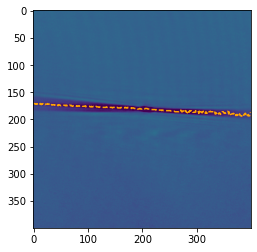

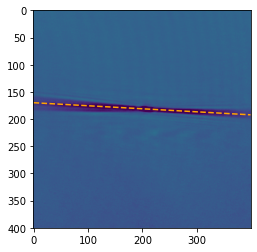

In [506]:
ab1_min = np.argmin(ab1[:,:,:],axis= 1)

plt.figure(1)
plt.imshow(ab1[1])
plt.plot(np.arange(ab1_min.shape[1]),ab1_min[0,:],'--',color = 'orange')
plt.clim([0.5,2])
plt.figure(2)

fit_x = np.arange(120,300,1)
fit_y = ab1_min[0,120:300]
# plt.plot(fit_x,fit_y,'--',color = 'orange')
res = np.polyfit(fit_x,fit_y,1)

plt.imshow(ab1[1])
plt.clim([0.5,2])
plt.plot(np.arange(400),np.arange(400)*res[0]+res[1],'--',color = 'orange')
print(res[0])
plt.ylim([400,0])


[14.65977122  0.22678659  0.96322885]


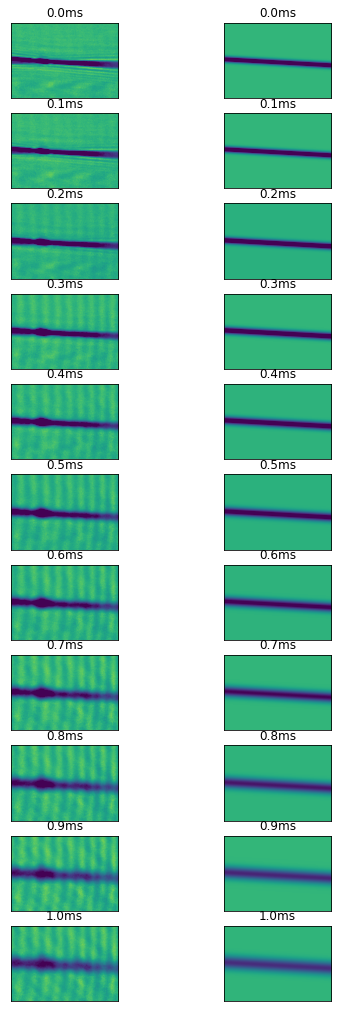

In [507]:
def gaussian2D(xy,sigma,amp,bias):
    x,y = xy
    d = (res[0] * x + res[1] - y) / np.sqrt(1+res[0]**2)
    return bias-amp * np.exp(-d**2/(2*sigma**2)) 
y = np.arange(ab1.shape[2])
x = np.arange(ab1.shape[1])
X,Y = np.meshgrid(x,y)
X_fit = X[110:250,150:350]
Y_fit = Y[110:250,150:350]
ab1_fit = ab1[:,110:250,150:350]

popt_all = np.zeros((ab1.shape[0],3))
sigma = np.zeros(ab1.shape[0])
for i in range(ab1.shape[0]):
    popt,pcov = curve_fit(gaussian2D,(X_fit.ravel(),Y_fit.ravel()),ab1_fit[i,:,:].ravel())
    sigma[i] = popt[0]
    popt_all[i,:] = popt

z_fit = gaussian2D((X_fit,Y_fit),*popt)

plt.figure(figsize=[7,18])
for i in range(11):
    plt.subplot(11,2,i*2+1)
    plt.imshow(ab1_fit[i,:,:])
    plt.clim([0.5,1.2]) 
    plt.xticks([])
    plt.yticks([])  
    plt.title('%.1f'%(0.1*i) + 'ms')
    plt.subplot(11,2,i*2+2)

    plt.imshow(gaussian2D((X_fit,Y_fit),*popt_all[i,:]))
    plt.clim([0.5,1.2])
    plt.xticks([])
    plt.yticks([]) 
    plt.title('%.1f'%(0.1*i) + 'ms')
    # plt.colorbar()
print(popt)
# [60:190,150:400]

33.602947652413945 um 41.115432044087726 uK


Text(0, 0.5, ' $\\sigma^2 (mm^2)$')

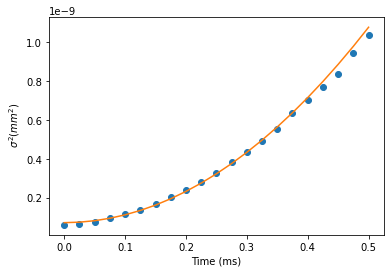

In [508]:
k_B = 1.3806504e-23
# Atomic mass of Rb85
m = 1.409993199e-25
# Gravitational aceleration
g = 9.7803

# def expansion(t,sigma_0, T,t0):
#     return sigma_0**2+k_B*T*(t-t0)**2/m
sigma = popt_all[:,0]
sigma_2 = (sigma * 5.86 * 1e-6 * 150/400)**2

def expansion(t,sigma_0, T):
    return sigma_0**2+k_B*T*(t)**2/m


popt, pcov = curve_fit(expansion,time[0:15]*1e-3, sigma_2[0:15])# ,bounds = ([0,0,0],[np.inf,np.inf,10e-3]))

print(popt[0]*4*1e6 , 'um', popt[1]*1e6 , 'uK')
plt.plot(time,sigma_2,'o')
plt.plot(time,expansion(time*1e-3,*popt))
plt.xlabel('Time (ms)')
plt.ylabel(r' $\sigma^2 (mm^2)$')




In [509]:
# system = 'Windows'

# if system == 'Mac':
#     folder_path = '/Volumes/Users/AMO lab/Documents/Rydberg Data/2023/11/27/PGC'
# else:
#     folder_path1 = 'C:\\Users\\AMO lab\\Documents\\Rydberg Data\\2024\\0105\\12'

# probe = plt.imread(folder_path1 + '\\' + 'probe.png').astype(np.float64)
# # bg = plt.imread(folder_path1 + '\\bg.png').astype(np.float64)
# img = np.zeros((11, probe.shape[0],probe.shape[1]))
# time = np.arange(0,1.1,0.1) 

# for i in range(0,len(time)):
#     # print(i)
#     if system == 'Mac':
#         img_temp = plt.imread(folder_path1+ '/' + i)
#     else:
#         img_temp = plt.imread(folder_path1+ '\\data_' + str(i) + '.png')
#         img_temp = img_temp.astype(np.float64)
#     img[i,:,:]=img_temp

In [510]:
# a = 500
# b = 900
# c = 800
# d = 1200
# img_crop = img[:,a:b,c:d]
# probe_crop = probe[a:b,c:d]
# ab1 = img_crop / probe_crop
# plt.figure(figsize = [14,6])
# for i in range(10):
#     plt.subplot(2,5,i+1)
#     plt.imshow((ab1[i,:,:]))
#     plt.title('%.1f'%(0.1*i) + 'ms')
#     # plt.colorbar()

In [511]:
# ab1_min = np.argmin(ab1[:,:,:],axis= 1)

# plt.figure(1)
# plt.imshow(ab1[1])
# plt.plot(np.arange(ab1_min.shape[1]),ab1_min[0,:],'--',color = 'orange')
# plt.clim([0.5,2])
# plt.figure(2)

# fit_x = np.arange(120,300,1)
# fit_y = ab1_min[0,120:300]
# # plt.plot(fit_x,fit_y,'--',color = 'orange')
# res = np.polyfit(fit_x,fit_y,1)

# plt.imshow(ab1[1])
# plt.clim([0.5,2])
# plt.plot(np.arange(400),np.arange(400)*res[0]+res[1],'--',color = 'orange')
# print(res[0])
# plt.ylim([400,0])

In [512]:
# def gaussian2D(xy,sigma,amp,bias):
#     x,y = xy
#     d = (res[0] * x + res[1] - y) / np.sqrt(1+res[0]**2)
#     return bias-amp * np.exp(-d**2/(2*sigma**2)) 
# y = np.arange(ab1.shape[2])
# x = np.arange(ab1.shape[1])
# X,Y = np.meshgrid(x,y)
# X_fit = X[110:250,150:350]
# Y_fit = Y[110:250,150:350]
# ab1_fit = ab1[:,110:250,150:350]

# popt_all = np.zeros((ab1.shape[0],3))
# sigma = np.zeros(ab1.shape[0])
# for i in range(ab1.shape[0]):
#     popt,pcov = curve_fit(gaussian2D,(X_fit.ravel(),Y_fit.ravel()),ab1_fit[i,:,:].ravel())
#     sigma[i] = popt[0]
#     popt_all[i,:] = popt

# z_fit = gaussian2D((X_fit,Y_fit),*popt)

# plt.figure(figsize=[7,18])
# for i in range(11):
#     plt.subplot(11,2,i*2+1)
#     plt.imshow(ab1_fit[i,:,:])
#     plt.clim([0.5,1.2]) 
#     plt.xticks([])
#     plt.yticks([])  
#     plt.title('%.1f'%(0.1*i) + 'ms')
#     plt.subplot(11,2,i*2+2)

#     plt.imshow(gaussian2D((X_fit,Y_fit),*popt_all[i,:]))
#     plt.clim([0.5,1.2])
#     plt.xticks([])
#     plt.yticks([]) 
#     plt.title('%.1f'%(0.1*i) + 'ms')
#     # plt.colorbar()
# print(popt)
# # [60:190,150:400]

In [513]:
P = [3.75,2.131,1.288,0.916,1.472,0.738,2.93,1.805]
T = [144.38359321921087, 83.6530058018315, 62.264071463662056,41.74766663492561, 65.64377202536322,37.849118153483396,105.42459897185087,57.4194763531417]

Text(0, 0.5, 'Temperature (uK)')

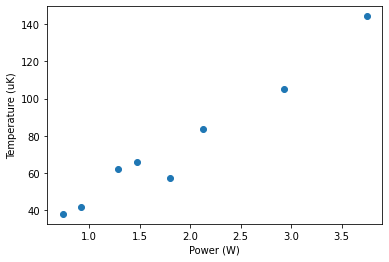

In [518]:
plt.plot(P,T,'o')
plt.xlabel('Power (W)')
plt.ylabel('Temperature (uK)')